In questo notebook sono applicate tecniche come DQN double, Dueling DQN e Prioritized Experience Replay al lavoro svolto nel file LNNLearning.ipynb

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import enviroment_no_visual as enviroment_no_visual
import enviroment_visual as enviroment_visual
import tensorflow as tf
import keras
import random

pygame 2.6.0 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-10-04 11:04:00.299628: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 11:04:00.306686: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 11:04:00.335846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 11:04:00.383779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 11:04:00.397368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 11:04:00.427950: I tensorflow/core/platform/cpu_feature_gu

Funzione per creare una neural network lineare 

In [2]:
class AdvantageLayer(keras.layers.Layer):
    def call(self, raw_advantages):
        return raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)

def Dueling_DQN(units):
    input_states = keras.layers.Input(shape=[11])
    hidden = keras.layers.Dense(units, activation="relu", name='HiddenLayer')(input_states)
    state_values = keras.layers.Dense(1, name='StateValueLayer')(hidden)
    raw_advantages = keras.layers.Dense(3, name='RawAdvantagesLayer')(hidden)
    advantages = AdvantageLayer(name='AdvantageCalculationLayer')(raw_advantages)
    Q_values = keras.layers.Add(name='QValueLayer')([state_values, advantages])
    model = keras.Model(inputs=[input_states], outputs=[Q_values], name='LinearQNetwork')
    return model
online_model = Dueling_DQN(256)
online_model.summary()

Model: "LinearQNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HiddenLayer (Dense) │ (None, 256)       │      3,072 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RawAdvantagesLayer  │ (None, 3)         │        771 │ HiddenLayer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ StateValueLayer     │ (None, 1)         │        257 │ HiddenLayer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AdvantageCalculati… │ (None, 3)         │          0 │ RawAdvantagesLay… │
│ (AdvantageLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ QValueLayer (Add)   │ (None, 3)         │          0 │ StateValueLayer[… │
│                     │                   │            │ AdvantageCalcula… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,100 (16.02 KB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

Implementazione di un buffer circolare che permetta inserimento/cancellazione degli elementi e accesso random veloce. 

In [3]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]
    
    def sample_experiences(self, batch_size):
        batch = self.sample(batch_size)
        states, actions, rewards, next_states, game_over = [
            np.array([experience[field_index] for experience in batch])
                        for field_index in range(5)]
        return states, actions, rewards, next_states, game_over

In [4]:
class PrioritizedReplayBuffer:
    def __init__(self, max_size, zeta=0.6):
        self.max_size = max_size
        self.zeta = zeta
        self.buffer = []
        self.priorities = np.zeros((max_size,), dtype=np.float32)
        self.pos = 0
    
    def add(self, experience, td_error):
        """
        Aggiunge una transizione alla memoria con priorità.
        experience: experience (stato, azione, ricompensa, prossimo stato, done)
        td_error: l'errore TD per la transizione, utilizzato per calcolare la priorità.
        """
        max_priority = np.max(self.priorities) if self.buffer else 1.0
        if len(self.buffer) < self.max_size:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience

        # Assegna la priorità basata sull'errore TD
        self.priorities[self.pos] = max_priority if td_error is None else (abs(td_error) + 1e-5) ** self.zeta
        self.pos = (self.pos + 1) % self.max_size
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.max_size:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.pos]
        
        # Probabilità di campionamento per ogni transizione
        probs = priorities ** self.zeta
        probs /= probs.sum()

        # Campiona gli indici con probabilità proporzionale alla priorità
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # Calcola i pesi di correzione per ciascun campione
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, weights
    
    def update_priorities(self, batch_indices, batch_td_errors):
        for idx, td_error in zip(batch_indices, batch_td_errors):
            self.priorities[idx] = (abs(td_error) + 1e-5) ** self.zeta

In [5]:
class QTrainer:
    def __init__(self, model, target_model, lr, gamma):
        self.online_model = model
        self.target_model = target_model
        self.gamma = gamma
        self.optimizer = keras.optimizers.Adam(learning_rate=lr)
        self.loss_fn = keras.losses.mean_squared_error
        
    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        next_Q_values = self.online_model(next_states)
        # Double DQN: l'online model sceglie l'azione dei prossimi stati ma i Q-Value sono stimati da target_model
        max_next_Q_values_by_model = tf.argmax(next_Q_values, axis=1)
        mask_for_target = tf.one_hot(max_next_Q_values_by_model, 3)
        max_next_Q_values_by_target = tf.reduce_sum(self.target_model(next_states) * mask_for_target, axis=1)
        
        # Equazione di Bellman: Q value = reward + discount factor * expected future reward
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values_by_target
        with tf.GradientTape() as tape:
            all_Q_values = self.online_model(states)  
            Q_values = tf.reduce_sum(all_Q_values * actions, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        # Backpropagation
        grads = tape.gradient(loss, self.online_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.online_model.trainable_variables))

In [6]:
# Espande di una dimensione. Quando si vuole (1,x) ma hai (1,)
def add_dimension(states, actions, rewards, next_states, dones):
    state = tf.expand_dims(states, axis=0)
    action = tf.expand_dims(actions, axis=0)
    reward = tf.expand_dims(rewards, axis=0)
    next_state = tf.expand_dims(next_states, axis=0)
    done = tf.expand_dims(dones, axis=0)
    return state, action, reward, next_state, done

def convert_to_tensorflow(states, actions, rewards, next_states, dones):
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
    dones = tf.convert_to_tensor(dones, dtype=tf.float32)
    return states, actions, rewards, next_states, dones

In [7]:
class Agent:
    def __init__(self, lr, gamma, max_memory, batch_size, nn_model):
        self.n_games = 0
        self.epsilon = 1  
        self.lr = lr
        self.gamma = gamma  
        self.memory = ReplayBuffer(max_size=max_memory)
        self.batch_size = batch_size
        self.model = nn_model
        self.target_model = keras.models.clone_model(self.model)
        self.trainer = QTrainer(self.model, self.target_model, lr=self.lr, gamma=self.gamma)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append(convert_to_tensorflow(state, action, reward, next_state, done))

    def train_memory(self):
            states, actions, rewards, next_states, dones = self.memory.sample_experiences(self.batch_size)
            self.trainer.train_step(states, actions, rewards, next_states, dones)

    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(3)
        else:
            Q_values = self.model(state[np.newaxis])
            return np.argmax(Q_values[0])
        
    def get_action(self, state):
        final_move = [0, 0, 0]  
        move = self.epsilon_greedy_policy(state)
        final_move[move] = 1
        return final_move
    
    def train_agent(self, N_GAME, visual=True):
        if visual:
            env = enviroment_visual.SnakeGameAI(speed=0)
        else:
            env = enviroment_no_visual.SnakeGameAI()
        score_list = []
        record = 0
        n_eps_zero = int(N_GAME*0.7)
        step=0
        while self.n_games < N_GAME:
            state_old = env.get_state()
            final_move = self.get_action(state_old)
            state_new, reward, done, score = env.play_step(final_move)
            self.remember(state_old, final_move, reward, state_new, done)

            if done:
                env.reset()
                self.n_games += 1
                self.train_memory()
                print(f"\rGame: {self.n_games}, Epsilon: {self.epsilon:3f}, Score: {score}, Record: {record}, Step eseguiti: {step}.", end="")
                self.epsilon = max(((n_eps_zero - self.n_games) / n_eps_zero), 0)
                if score > record:
                    record = score
                    self.save_model()
                score_list.append(score)
            step+=1
        return score_list

    def save_model(self, model_dir_path="./DQNmodel", file_name='model.keras'):
        if not os.path.exists(model_dir_path):
            print(f"La cartella non esiste. Sarà creata con nome: {model_dir_path}")
            os.mkdir(model_dir_path)
        file_name = os.path.join(model_dir_path, file_name)
        self.model.save(file_name)

Mostra andamento dello score per partita durante il training

In [8]:
def plot_trand(scores, save_path=None):
    zeros = [0 for i in range(49)]
    calcola_media = lambda i: sum(scores[i-50:i+1]) / 50
    media_precedenti = zeros + list(map(calcola_media, range(49, len(scores))))
    max_mean_value = max(media_precedenti)
    max_mean_index = media_precedenti.index(max_mean_value)
    plt.plot(scores, label='Score')
    plt.plot(media_precedenti, label='Mean score delle ultime 50 partite')
    plt.text(max_mean_index, max_mean_value, f'{max_mean_value:.2f}', fontsize=12, color="darkorange", ha='center')

    plt.title("Andamento del training.")
    plt.xlabel("Partite")
    plt.ylabel("Score")
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Crea e allena un agente

Game: 500, Epsilon: 0.000000, Score: 28, Record: 52, Step eseguiti: 99551.

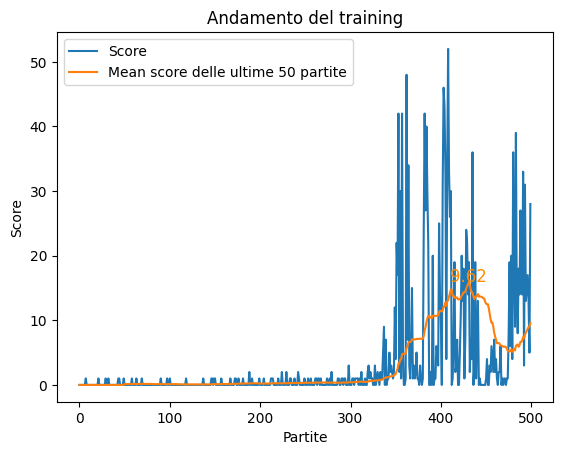

In [9]:
online_model = Dueling_DQN(128)
agent = Agent(lr=0.05, gamma=0.9, max_memory=20_000, batch_size=1024, nn_model=online_model)
plot_scores = agent.train_agent(N_GAME=500, visual=False)
plot_trand(plot_scores)